In [1]:
from openff.toolkit.topology import Molecule, Topology
from openff.toolkit.typing.engines.smirnoff import ForceField
import numpy as np
import pickle
import logging

In [2]:
logging.getLogger("openff").setLevel(logging.ERROR)
logging.getLogger("numpy").setLevel(logging.ERROR)

In [3]:
def show_oemol_struc(oemol, torsions=False, atom_indices=[], width=400, height=200):
    from IPython.display import Image
    from openeye import oechem, oedepict

    # Highlight element of interest
    class NoAtom(oechem.OEUnaryAtomPred):
        def __call__(self, atom):
            return False

    class AtomInTorsion(oechem.OEUnaryAtomPred):
        def __call__(self, atom):
            return atom.GetIdx() in atom_indices

    class NoBond(oechem.OEUnaryBondPred):
        def __call__(self, bond):
            return False

    class BondInTorsion(oechem.OEUnaryBondPred):
        def __call__(self, bond):
            return (bond.GetBgn().GetIdx() in atom_indices) and (
                bond.GetEnd().GetIdx() in atom_indices
            )

    class CentralBondInTorsion(oechem.OEUnaryBondPred):
        def __call__(self, bond):
            return (bond.GetBgn().GetIdx() in atom_indices[1:3]) and (
                bond.GetEnd().GetIdx() in atom_indices[1:3]
            )

    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    opts.SetAtomPropertyFunctor(oedepict.OEDisplayAtomIdx())

    oedepict.OEPrepareDepiction(oemol)
    img = oedepict.OEImage(width, height)
    display = oedepict.OE2DMolDisplay(oemol, opts)
    if torsions:
        atoms = oemol.GetAtoms(AtomInTorsion())
        bonds = oemol.GetBonds(NoBond())
        abset = oechem.OEAtomBondSet(atoms, bonds)
        oedepict.OEAddHighlighting(
            display,
            oechem.OEColor(oechem.OEYellow),
            oedepict.OEHighlightStyle_BallAndStick,
            abset,
        )

    oedepict.OERenderMolecule(img, display)
    png = oedepict.OEWriteImageToString("png", img)
    return Image(png)

def create_tagged_molecules(smiles, forcefield, torsion_params):
    from openff.qcsubmit.workflow_components import TorsionIndexer
    
    torsion_indexer = TorsionIndexer()
    molecules = []
    cmiles_list = []
    
    for item in smiles:
        offmol = Molecule.from_smiles(item, allow_undefined_stereo=True)
        topology = Topology.from_molecules([offmol])

        # Run the molecule labeling
        molecule_force_list = forcefield.label_molecules(topology)

        # Print out a formatted description of the parameters applied to this molecule
        for mol_idx, mol_forces in enumerate(molecule_force_list):
            for force_tag, force_dict in mol_forces.items():
                if force_tag == "ProperTorsions":
                    for (atom_indices, parameter) in force_dict.items():
                        if parameter.id in torsion_params:
                            torsion_indexer = TorsionIndexer()
                            torsion_indexer.add_torsion(atom_indices, (0,3), (-165, 180))
                            offmol.properties["dihedrals"] = torsion_indexer
                            molecules.append(offmol)    
                            cmiles_list.append((offmol.to_smiles(mapped=True), atom_indices))
                            display(show_oemol_struc(offmol.to_openeye(), torsions=True, atom_indices=atom_indices))
                            print(parameter.id, offmol.to_smiles(mapped=True), atom_indices)
                            break
    
    return molecules, cmiles_list

/home/maverick/anaconda3/envs/qcarchive-user-submit/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/maverick/anaconda3/envs/qcarchive-user-submit/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/maverick/anaconda3/envs/qcarchive-user-submit/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/maverick/anaconda3/envs/qcarchive-user-submit/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_s

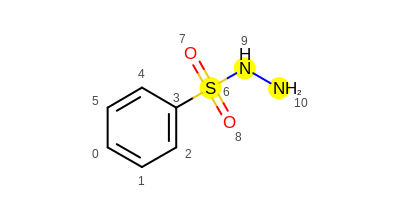

t130b [H:12][c:1]1[c:2]([c:3]([c:4]([c:5]([c:6]1[H:16])[H:15])[S:7](=[O:8])(=[O:9])[N:10]([H:17])[N:11]([H:18])[H:19])[H:14])[H:13] (6, 9, 10, 17)


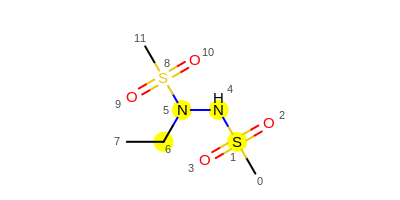

t130b [H:19][C:8]([H:20])([H:21])[C:7]([H:17])([H:18])[N:6]([N:5]([H:16])[S:2](=[O:3])(=[O:4])[C:1]([H:13])([H:14])[H:15])[S:9](=[O:10])(=[O:11])[C:12]([H:22])([H:23])[H:24] (1, 4, 5, 6)


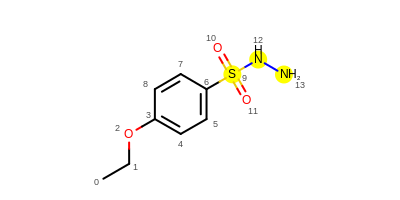

t130b [H:20][c:5]1[c:6]([c:7]([c:8]([c:9]([c:4]1[O:3][C:2]([H:18])([H:19])[C:1]([H:15])([H:16])[H:17])[H:23])[H:22])[S:10](=[O:11])(=[O:12])[N:13]([H:24])[N:14]([H:25])[H:26])[H:21] (9, 12, 13, 24)


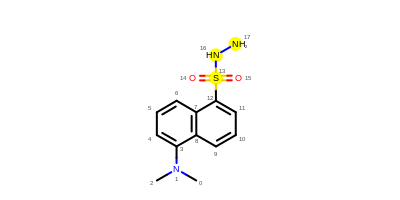

t130b [H:26][c:6]1[c:7]([c:8]2[c:9]([c:10]([c:11]([c:12]([c:13]2[S:14](=[O:15])(=[O:16])[N:17]([H:31])[N:18]([H:32])[H:33])[H:30])[H:29])[H:28])[c:4]([c:5]1[H:25])[N:2]([C:1]([H:19])([H:20])[H:21])[C:3]([H:22])([H:23])[H:24])[H:27] (13, 16, 17, 31)


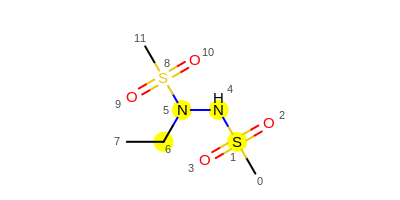

t130b [H:19][C:8]([H:20])([H:21])[C:7]([H:17])([H:18])[N:6]([N:5]([H:16])[S:2](=[O:3])(=[O:4])[C:1]([H:13])([H:14])[H:15])[S:9](=[O:10])(=[O:11])[C:12]([H:22])([H:23])[H:24] (1, 4, 5, 6)


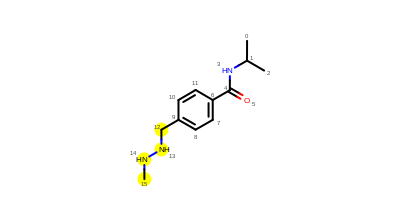

t130b [H:25][c:8]1[c:9]([c:10]([c:11]([c:12]([c:7]1[C:5](=[O:6])[N:4]([H:24])[C:2]([H:20])([C:1]([H:17])([H:18])[H:19])[C:3]([H:21])([H:22])[H:23])[H:28])[H:27])[C:13]([H:29])([H:30])[N:14]([H:31])[N:15]([H:32])[C:16]([H:33])([H:34])[H:35])[H:26] (12, 13, 14, 15)


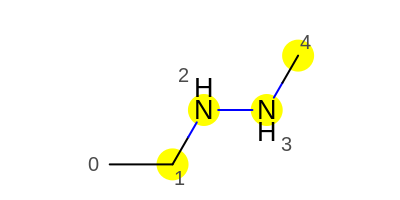

t130b [H:6][C:1]([H:7])([H:8])[C:2]([H:9])([H:10])[N:3]([H:11])[N:4]([H:12])[C:5]([H:13])([H:14])[H:15] (1, 2, 3, 4)


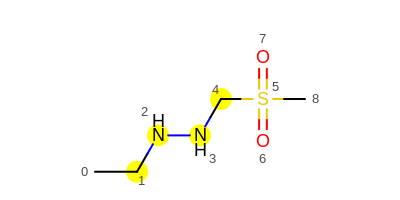

t130b [H:10][C:1]([H:11])([H:12])[C:2]([H:13])([H:14])[N:3]([H:15])[N:4]([H:16])[C:5]([H:17])([H:18])[S:6](=[O:7])(=[O:8])[C:9]([H:19])([H:20])[H:21] (1, 2, 3, 4)


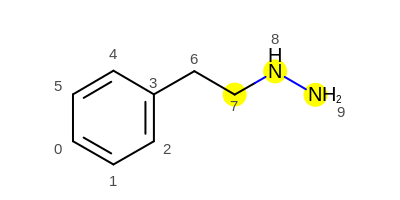

t132b [H:11][c:1]1[c:2]([c:3]([c:4]([c:5]([c:6]1[H:15])[H:14])[C:7]([H:16])([H:17])[C:8]([H:18])([H:19])[N:9]([H:20])[N:10]([H:21])[H:22])[H:13])[H:12] (7, 8, 9, 20)


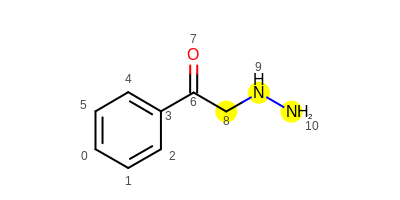

t132b [H:12][c:1]1[c:2]([c:3]([c:4]([c:5]([c:6]1[H:16])[H:15])[C:7](=[O:8])[C:9]([H:17])([H:18])[N:10]([H:19])[N:11]([H:20])[H:21])[H:14])[H:13] (8, 9, 10, 19)


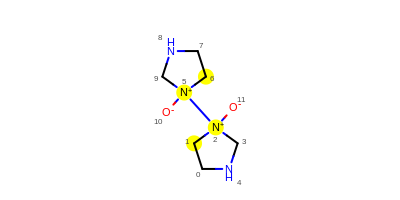

t133 [H:13][C:1]1([C:2]([N+:3]([C:4]([N:5]1[H:19])([H:17])[H:18])([N+:6]2([C:7]([C:8]([N:9]([C:10]2([H:25])[H:26])[H:24])([H:22])[H:23])([H:20])[H:21])[O-:11])[O-:12])([H:15])[H:16])[H:14] (1, 2, 5, 6)


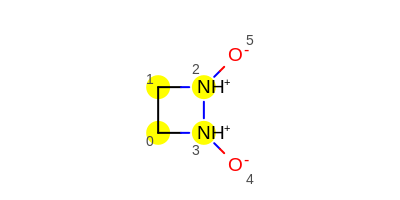

t133 [H:7][C:1]1([C:2]([N+:3]([N+:4]1([H:12])[O-:5])([H:11])[O-:6])([H:9])[H:10])[H:8] (0, 3, 2, 1)


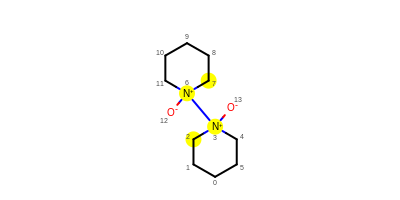

t133 [H:15][C:1]1([C:2]([C:3]([N+:4]([C:5]([C:6]1([H:23])[H:24])([H:21])[H:22])([N+:7]2([C:8]([C:9]([C:10]([C:11]([C:12]2([H:33])[H:34])([H:31])[H:32])([H:29])[H:30])([H:27])[H:28])([H:25])[H:26])[O-:13])[O-:14])([H:19])[H:20])([H:17])[H:18])[H:16] (2, 3, 6, 7)


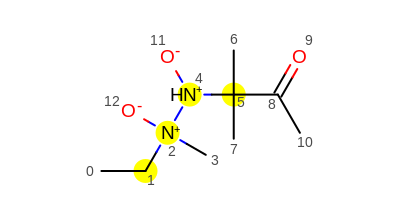

t133 [H:29][C:11]([H:30])([H:31])[C:9](=[O:10])[C:6]([C:7]([H:23])([H:24])[H:25])([C:8]([H:26])([H:27])[H:28])[N+:5]([H:22])([N+:3]([C:4]([H:19])([H:20])[H:21])([C:2]([H:17])([H:18])[C:1]([H:14])([H:15])[H:16])[O-:13])[O-:12] (1, 2, 4, 5)


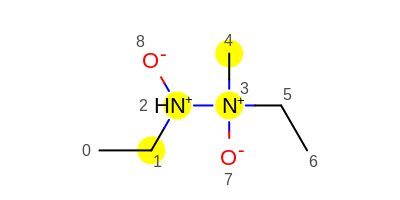

t133 [H:10][C:1]([H:11])([H:12])[C:2]([H:13])([H:14])[N+:3]([H:15])([N+:4]([C:5]([H:16])([H:17])[H:18])([C:6]([H:19])([H:20])[C:7]([H:21])([H:22])[H:23])[O-:8])[O-:9] (1, 2, 3, 4)


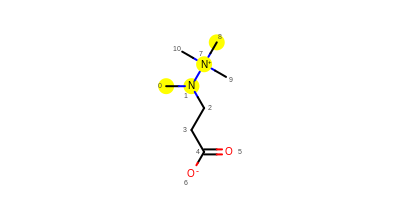

t133a [H:12][C:1]([H:13])([H:14])[N:2]([C:3]([H:15])([H:16])[C:4]([H:17])([H:18])[C:5](=[O:6])[O-:7])[N+:8]([C:9]([H:19])([H:20])[H:21])([C:10]([H:22])([H:23])[H:24])[C:11]([H:25])([H:26])[H:27] (0, 1, 7, 8)


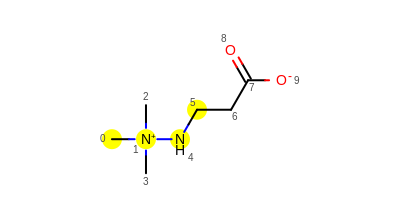

t133a [H:11][C:1]([H:12])([H:13])[N+:2]([C:3]([H:14])([H:15])[H:16])([C:4]([H:17])([H:18])[H:19])[N:5]([H:20])[C:6]([H:21])([H:22])[C:7]([H:23])([H:24])[C:8](=[O:9])[O-:10] (0, 1, 4, 5)


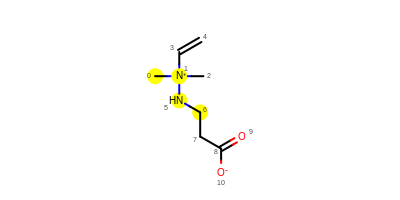

t133a [H:19][C:5](=[C:4]([H:18])[N+:2]([C:1]([H:12])([H:13])[H:14])([C:3]([H:15])([H:16])[H:17])[N:6]([H:21])[C:7]([H:22])([H:23])[C:8]([H:24])([H:25])[C:9](=[O:10])[O-:11])[H:20] (0, 1, 5, 6)


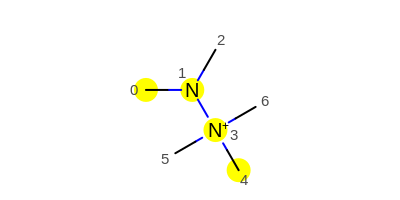

t133a [H:8][C:1]([H:9])([H:10])[N:2]([C:3]([H:11])([H:12])[H:13])[N+:4]([C:5]([H:14])([H:15])[H:16])([C:6]([H:17])([H:18])[H:19])[C:7]([H:20])([H:21])[H:22] (0, 1, 3, 4)


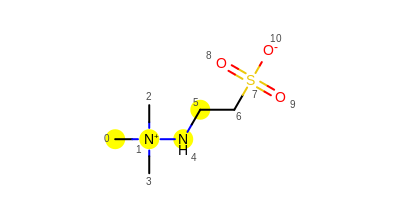

t133a [H:12][C:1]([H:13])([H:14])[N+:2]([C:3]([H:15])([H:16])[H:17])([C:4]([H:18])([H:19])[H:20])[N:5]([H:21])[C:6]([H:22])([H:23])[C:7]([H:24])([H:25])[S:8](=[O:9])(=[O:10])[O-:11] (0, 1, 4, 5)


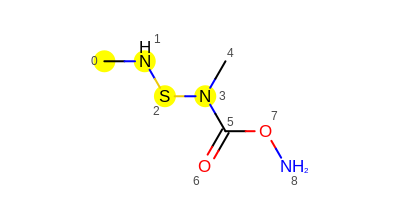

t142b [H:10][C:1]([H:11])([H:12])[N:2]([H:13])[S:3][N:4]([C:6](=[O:7])[O:8][N:9]([H:17])[H:18])[C:5]([H:14])([H:15])[H:16] (0, 1, 2, 3)


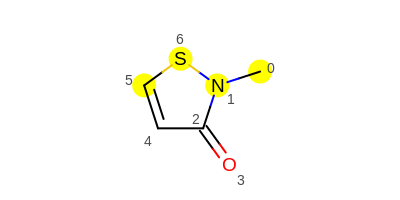

t142b [H:11][C:5]1=[C:6]([S:7][N:2]([C:3]1=[O:4])[C:1]([H:8])([H:9])[H:10])[H:12] (0, 1, 6, 5)


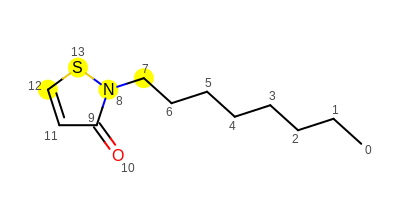

t142b [H:32][C:12]1=[C:13]([S:14][N:9]([C:10]1=[O:11])[C:8]([H:30])([H:31])[C:7]([H:28])([H:29])[C:6]([H:26])([H:27])[C:5]([H:24])([H:25])[C:4]([H:22])([H:23])[C:3]([H:20])([H:21])[C:2]([H:18])([H:19])[C:1]([H:15])([H:16])[H:17])[H:33] (7, 8, 13, 12)


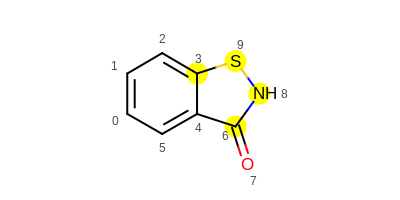

t142b [H:11][c:1]1[c:2]([c:3]([c:4]2[c:5]([c:6]1[H:14])[C:7](=[O:8])[N:9]([S:10]2)[H:15])[H:13])[H:12] (3, 9, 8, 6)


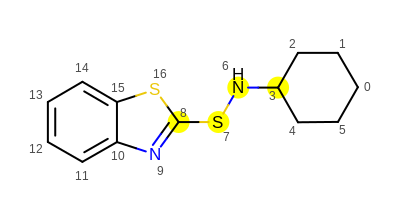

t142b [H:31][c:13]1[c:14]([c:15]([c:16]2[c:11]([c:12]1[H:30])[N:10]=[C:9]([S:17]2)[S:8][N:7]([H:29])[C:4]3([C:3]([C:2]([C:1]([C:6]([C:5]3([H:25])[H:26])([H:27])[H:28])([H:18])[H:19])([H:20])[H:21])([H:22])[H:23])[H:24])[H:33])[H:32] (3, 6, 7, 8)


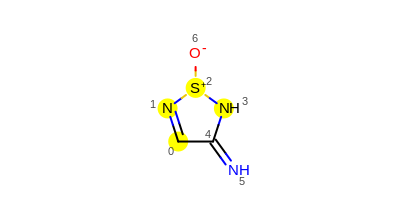

t142d [H:8][C:1]1=[N:2][S+:3]([N:4]([C:5]1=[N:6][H:10])[H:9])[O-:7] (0, 1, 2, 3)


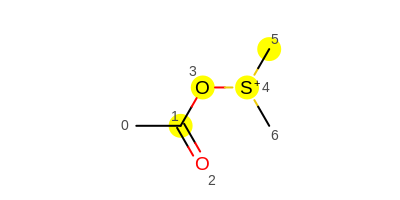

t142d [H:8][C:1]([H:9])([H:10])[C:2](=[O:3])[O:4][S+:5]([C:6]([H:11])([H:12])[H:13])[C:7]([H:14])([H:15])[H:16] (1, 3, 4, 5)


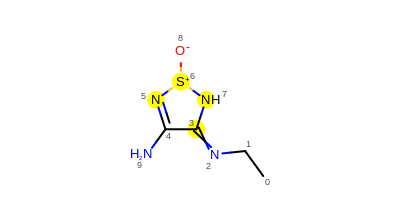

t142e [H:11][C:1]([H:12])([H:13])[C:2]([H:14])([H:15])[N:3]=[C:4]1[C:5](=[N:6][S+:7]([N:8]1[H:16])[O-:9])[N:10]([H:17])[H:18] (3, 7, 6, 5)


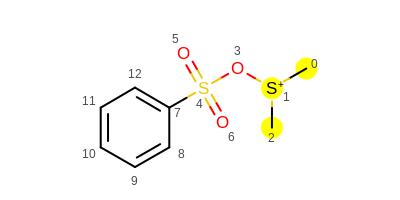

t116c [H:22][c:11]1[c:10]([c:9]([c:8]([c:13]([c:12]1[H:23])[H:24])[S:5](=[O:6])(=[O:7])[O:4][S+:2]([C:1]([H:14])([H:15])[H:16])[C:3]([H:17])([H:18])[H:19])[H:20])[H:21] (0, 1, 2, 16)


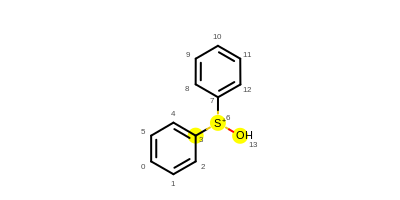

t142d [H:15][c:1]1[c:2]([c:3]([c:4]([c:5]([c:6]1[H:19])[H:18])[S+:7]([c:8]2[c:9]([c:10]([c:11]([c:12]([c:13]2[H:24])[H:23])[H:22])[H:21])[H:20])[O:14][H:25])[H:17])[H:16] (3, 6, 13, 24)


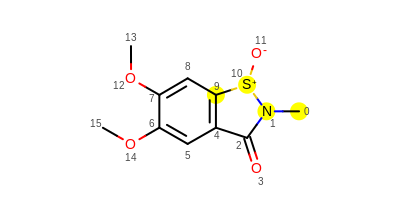

t142e [H:20][c:6]1[c:5]2[c:10]([c:9]([c:8]([c:7]1[O:15][C:16]([H:25])([H:26])[H:27])[O:13][C:14]([H:22])([H:23])[H:24])[H:21])[S+:11]([N:2]([C:3]2=[O:4])[C:1]([H:17])([H:18])[H:19])[O-:12] (0, 1, 10, 9)


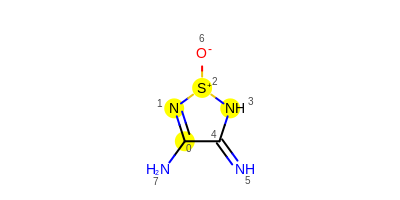

t142d [H:10][N:6]=[C:5]1[C:1](=[N:2][S+:3]([N:4]1[H:9])[O-:7])[N:8]([H:11])[H:12] (0, 1, 2, 3)


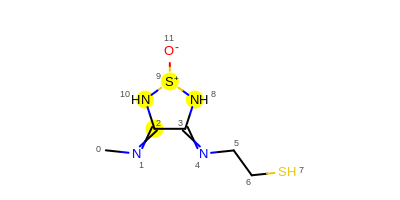

t142e [H:13][C:1]([H:14])([H:15])[N:2]=[C:3]1[C:4](=[N:5][C:6]([H:16])([H:17])[C:7]([H:18])([H:19])[S:8][H:20])[N:9]([S+:10]([N:11]1[H:22])[O-:12])[H:21] (2, 10, 9, 8)


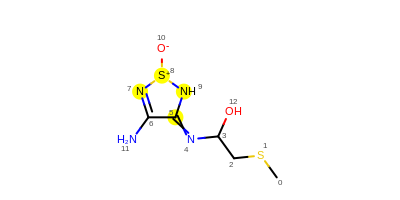

t142e [H:14][C:1]([H:15])([H:16])[S:2][C:3]([H:17])([H:18])[C:4]([H:19])([N:5]=[C:6]1[C:7](=[N:8][S+:9]([N:10]1[H:20])[O-:11])[N:12]([H:21])[H:22])[O:13][H:23] (5, 9, 8, 7)


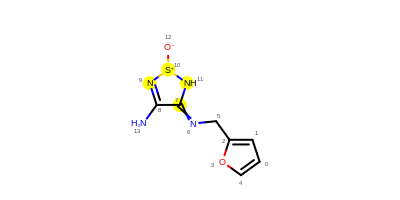

t142e [H:15][C:1]1=[C:5]([O:4][C:3](=[C:2]1[H:16])[C:6]([H:18])([H:19])[N:7]=[C:8]2[C:9](=[N:10][S+:11]([N:12]2[H:20])[O-:13])[N:14]([H:21])[H:22])[H:17] (7, 11, 10, 9)


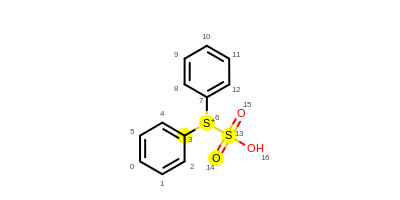

t142f [H:18][c:1]1[c:2]([c:3]([c:4]([c:5]([c:6]1[H:22])[H:21])[S+:7]([c:8]2[c:9]([c:10]([c:11]([c:12]([c:13]2[H:27])[H:26])[H:25])[H:24])[H:23])[S:14](=[O:15])(=[O:16])[O:17][H:28])[H:20])[H:19] (3, 6, 13, 14)


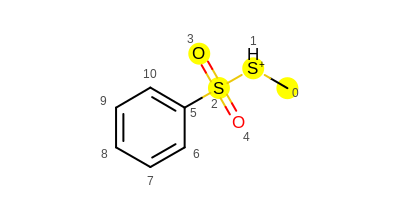

t142f [H:18][c:9]1[c:8]([c:7]([c:6]([c:11]([c:10]1[H:19])[H:20])[S:3](=[O:4])(=[O:5])[S+:2]([H:15])[C:1]([H:12])([H:13])[H:14])[H:16])[H:17] (0, 1, 2, 3)


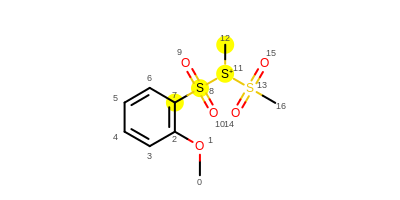

t142f [H:22][c:5]1[c:6]([c:7]([c:8]([c:3]([c:4]1[H:21])[O:2][C:1]([H:18])([H:19])[H:20])[S:9](=[O:10])(=[O:11])[S+:12]([C:13]([H:25])([H:26])[H:27])[S:14](=[O:15])(=[O:16])[C:17]([H:28])([H:29])[H:30])[H:24])[H:23] (7, 8, 11, 12)


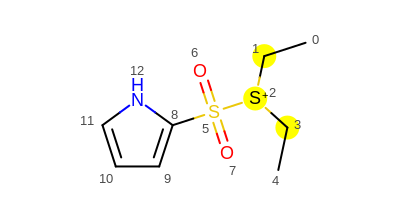

t116c [H:25][C:11]1=[C:12]([N:13]([C:9](=[C:10]1[H:24])[S:6](=[O:7])(=[O:8])[S+:3]([C:2]([H:17])([H:18])[C:1]([H:14])([H:15])[H:16])[C:4]([H:19])([H:20])[C:5]([H:21])([H:22])[H:23])[H:27])[H:26] (1, 2, 3, 18)


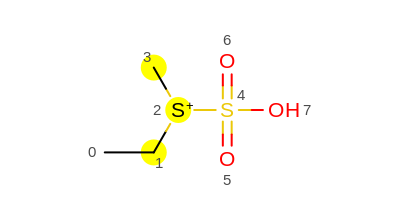

t116c [H:9][C:1]([H:10])([H:11])[C:2]([H:12])([H:13])[S+:3]([C:4]([H:14])([H:15])[H:16])[S:5](=[O:6])(=[O:7])[O:8][H:17] (1, 2, 3, 13)


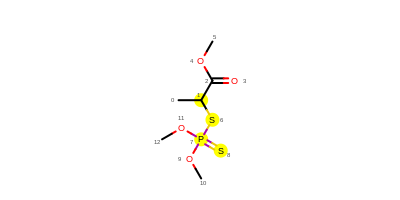

t142c [H:14][C:1]([H:15])([H:16])[C:2]([H:17])([C:3](=[O:4])[O:5][C:6]([H:18])([H:19])[H:20])[S:7][P:8](=[S:9])([O:10][C:11]([H:21])([H:22])[H:23])[O:12][C:13]([H:24])([H:25])[H:26] (1, 6, 7, 8)


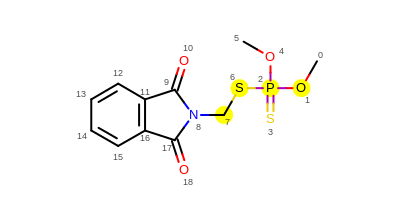

t142c [H:29][c:14]1[c:15]([c:16]([c:17]2[c:12]([c:13]1[H:28])[C:10](=[O:11])[N:9]([C:18]2=[O:19])[C:8]([H:26])([H:27])[S:7][P:3](=[S:4])([O:2][C:1]([H:20])([H:21])[H:22])[O:5][C:6]([H:23])([H:24])[H:25])[H:31])[H:30] (1, 2, 6, 7)


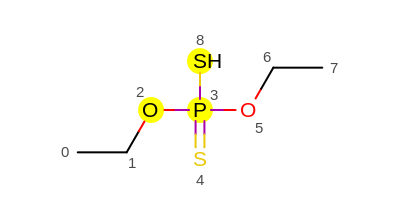

t142c [H:10][C:1]([H:11])([H:12])[C:2]([H:13])([H:14])[O:3][P:4](=[S:5])([O:6][C:7]([H:15])([H:16])[C:8]([H:17])([H:18])[H:19])[S:9][H:20] (2, 3, 8, 19)


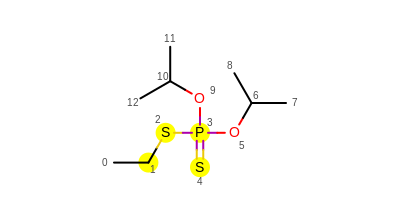

t142c [H:14][C:1]([H:15])([H:16])[C:2]([H:17])([H:18])[S:3][P:4](=[S:5])([O:6][C:7]([H:19])([C:8]([H:20])([H:21])[H:22])[C:9]([H:23])([H:24])[H:25])[O:10][C:11]([H:26])([C:12]([H:27])([H:28])[H:29])[C:13]([H:30])([H:31])[H:32] (1, 2, 3, 4)


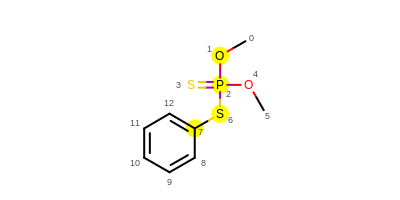

t142c [H:22][c:11]1[c:10]([c:9]([c:8]([c:13]([c:12]1[H:23])[H:24])[S:7][P:3](=[S:4])([O:2][C:1]([H:14])([H:15])[H:16])[O:5][C:6]([H:17])([H:18])[H:19])[H:20])[H:21] (1, 2, 6, 7)


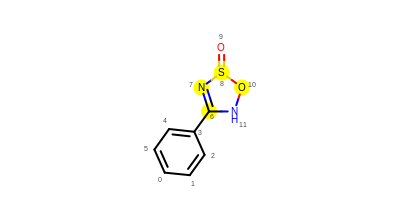

t143d [H:13][c:1]1[c:2]([c:3]([c:4]([c:5]([c:6]1[H:17])[H:16])[C:7]2=[N:8][S:9](=[O:10])[O:11][N:12]2[H:18])[H:15])[H:14] (6, 7, 8, 10)


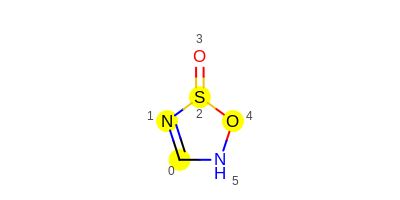

t143d [H:7][C:1]1=[N:2][S:3](=[O:4])[O:5][N:6]1[H:8] (0, 1, 2, 4)


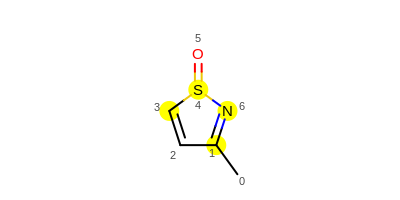

t143d [H:11][C:3]1=[C:4]([S:5](=[O:6])[N:7]=[C:2]1[C:1]([H:8])([H:9])[H:10])[H:12] (1, 6, 4, 3)


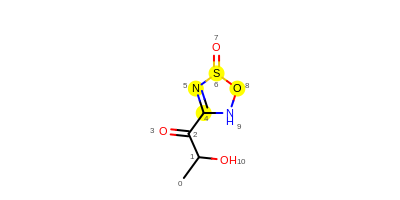

t143d [H:12][C:1]([H:13])([H:14])[C:2]([H:15])([C:3](=[O:4])[C:5]1=[N:6][S:7](=[O:8])[O:9][N:10]1[H:16])[O:11][H:17] (4, 5, 6, 8)


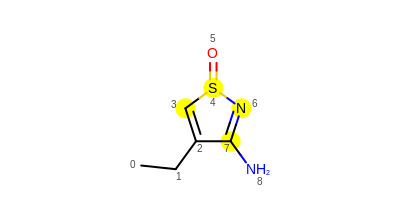

t143d [H:15][C:4]1=[C:3]([C:8](=[N:7][S:5]1=[O:6])[N:9]([H:16])[H:17])[C:2]([H:13])([H:14])[C:1]([H:10])([H:11])[H:12] (3, 4, 6, 7)


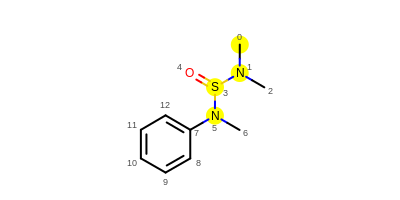

t143e [H:25][c:11]1[c:10]([c:9]([c:8]([c:13]([c:12]1[H:26])[H:27])[N:6]([C:7]([H:20])([H:21])[H:22])[S:4](=[O:5])[N:2]([C:1]([H:14])([H:15])[H:16])[C:3]([H:17])([H:18])[H:19])[H:23])[H:24] (0, 1, 3, 5)


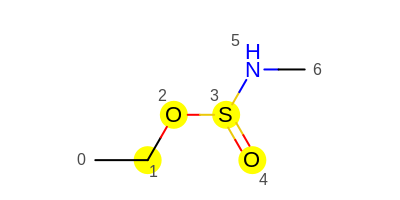

t157a [H:8][C:1]([H:9])([H:10])[C:2]([H:11])([H:12])[O:3][S:4](=[O:5])[N:6]([H:13])[C:7]([H:14])([H:15])[H:16] (1, 2, 3, 4)


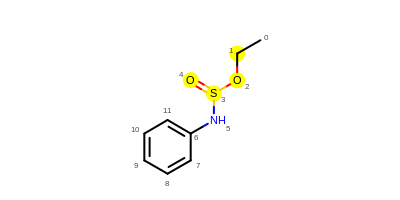

t157a [H:21][c:10]1[c:9]([c:8]([c:7]([c:12]([c:11]1[H:22])[H:23])[N:6]([H:18])[S:4](=[O:5])[O:3][C:2]([H:16])([H:17])[C:1]([H:13])([H:14])[H:15])[H:19])[H:20] (1, 2, 3, 4)


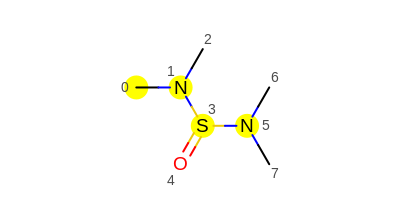

t143e [H:9][C:1]([H:10])([H:11])[N:2]([C:3]([H:12])([H:13])[H:14])[S:4](=[O:5])[N:6]([C:7]([H:15])([H:16])[H:17])[C:8]([H:18])([H:19])[H:20] (0, 1, 3, 5)


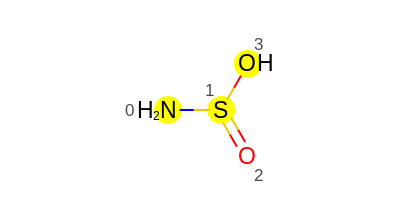

t157a [H:5][N:1]([H:6])[S:2](=[O:3])[O:4][H:7] (0, 1, 3, 6)


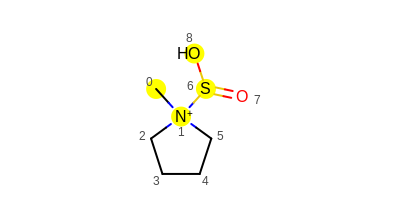

t143f [H:15][C:4]1([C:5]([C:6]([N+:2]([C:3]1([H:13])[H:14])([C:1]([H:10])([H:11])[H:12])[S:7](=[O:8])[O:9][H:21])([H:19])[H:20])([H:17])[H:18])[H:16] (0, 1, 6, 8)


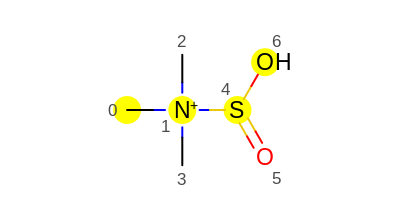

t143f [H:8][C:1]([H:9])([H:10])[N+:2]([C:3]([H:11])([H:12])[H:13])([C:4]([H:14])([H:15])[H:16])[S:5](=[O:6])[O:7][H:17] (0, 1, 4, 6)


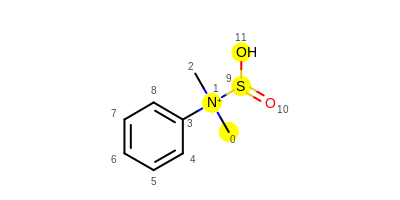

t143f [H:21][c:7]1[c:6]([c:5]([c:4]([c:9]([c:8]1[H:22])[H:23])[N+:2]([C:1]([H:13])([H:14])[H:15])([C:3]([H:16])([H:17])[H:18])[S:10](=[O:11])[O:12][H:24])[H:19])[H:20] (0, 1, 9, 11)


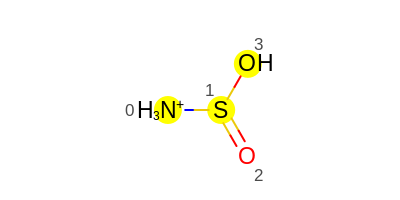

t157a [H:5][N+:1]([H:6])([H:7])[S:2](=[O:3])[O:4][H:8] (0, 1, 3, 7)


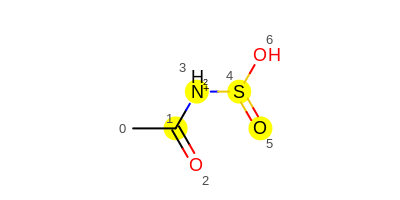

t143f [H:8][C:1]([H:9])([H:10])[C:2](=[O:3])[N+:4]([H:11])([H:12])[S:5](=[O:6])[O:7][H:13] (1, 3, 4, 5)


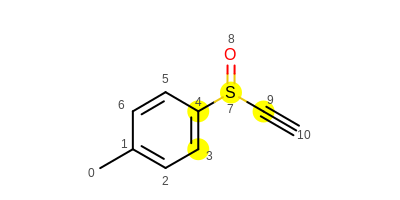

t122d [H:19][C:11]#[C:10][S:8](=[O:9])[c:5]1[c:4]([c:3]([c:2]([c:7]([c:6]1[H:17])[H:18])[C:1]([H:12])([H:13])[H:14])[H:15])[H:16] (3, 4, 7, 9)


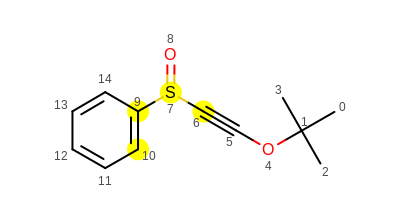

t122d [H:27][c:13]1[c:12]([c:11]([c:10]([c:15]([c:14]1[H:28])[H:29])[S:8](=[O:9])[C:7]#[C:6][O:5][C:2]([C:1]([H:16])([H:17])[H:18])([C:3]([H:19])([H:20])[H:21])[C:4]([H:22])([H:23])[H:24])[H:25])[H:26] (6, 7, 9, 10)


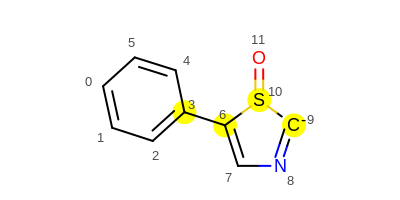

t122d [H:13][c:1]1[c:2]([c:3]([c:4]([c:5]([c:6]1[H:17])[H:16])[C:7]2=[C:8]([N:9]=[C-:10][S:11]2=[O:12])[H:18])[H:15])[H:14] (3, 6, 10, 9)


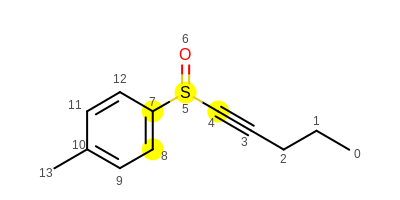

t122d [H:23][c:10]1[c:9]([c:8]([c:13]([c:12]([c:11]1[C:14]([H:26])([H:27])[H:28])[H:24])[H:25])[S:6](=[O:7])[C:5]#[C:4][C:3]([H:20])([H:21])[C:2]([H:18])([H:19])[C:1]([H:15])([H:16])[H:17])[H:22] (4, 5, 7, 8)


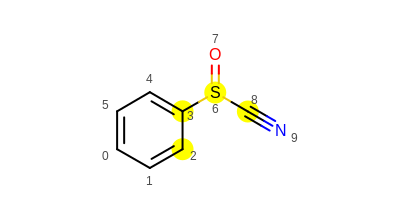

t122d [H:11][c:1]1[c:2]([c:3]([c:4]([c:5]([c:6]1[H:15])[H:14])[S:7](=[O:8])[C:9]#[N:10])[H:13])[H:12] (2, 3, 6, 8)


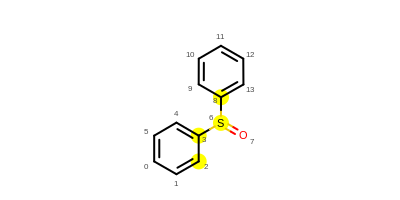

t122e [H:15][c:1]1[c:2]([c:3]([c:4]([c:5]([c:6]1[H:19])[H:18])[S:7](=[O:8])[c:9]2[c:10]([c:11]([c:12]([c:13]([c:14]2[H:24])[H:23])[H:22])[H:21])[H:20])[H:17])[H:16] (2, 3, 6, 8)


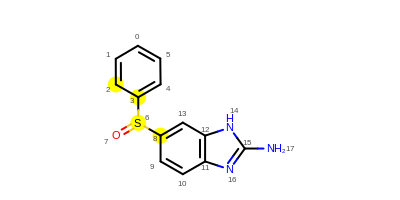

t122e [H:19][c:1]1[c:2]([c:3]([c:4]([c:5]([c:6]1[H:23])[H:22])[S:7](=[O:8])[c:9]2[c:10]([c:11]([c:12]3[c:13]([c:14]2[H:26])[N:15]([C:16](=[N:17]3)[N:18]([H:28])[H:29])[H:27])[H:25])[H:24])[H:21])[H:20] (2, 3, 6, 8)


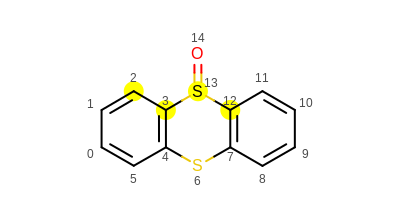

t122e [H:16][c:1]1[c:2]([c:3]([c:4]2[c:5]([c:6]1[H:19])[S:7][c:8]3[c:9]([c:10]([c:11]([c:12]([c:13]3[S:14]2=[O:15])[H:23])[H:22])[H:21])[H:20])[H:18])[H:17] (2, 3, 13, 12)


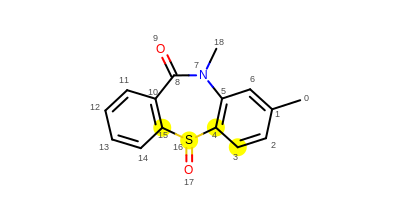

t122e [H:27][c:13]1[c:14]([c:15]([c:16]2[c:11]([c:12]1[H:26])[C:9](=[O:10])[N:8]([c:6]3[c:7]([c:2]([c:3]([c:4]([c:5]3[S:17]2=[O:18])[H:24])[H:23])[C:1]([H:20])([H:21])[H:22])[H:25])[C:19]([H:30])([H:31])[H:32])[H:29])[H:28] (3, 4, 16, 15)


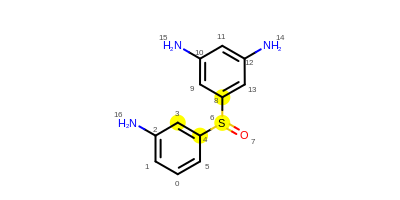

t122e [H:18][c:1]1[c:2]([c:3]([c:4]([c:5]([c:6]1[H:21])[S:7](=[O:8])[c:9]2[c:10]([c:11]([c:12]([c:13]([c:14]2[H:24])[N:15]([H:25])[H:26])[H:23])[N:16]([H:27])[H:28])[H:22])[H:20])[N:17]([H:29])[H:30])[H:19] (3, 4, 6, 8)


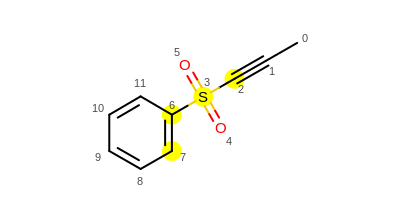

t122a [H:18][c:10]1[c:9]([c:8]([c:7]([c:12]([c:11]1[H:19])[H:20])[S:4](=[O:5])(=[O:6])[C:3]#[C:2][C:1]([H:13])([H:14])[H:15])[H:16])[H:17] (2, 3, 6, 7)


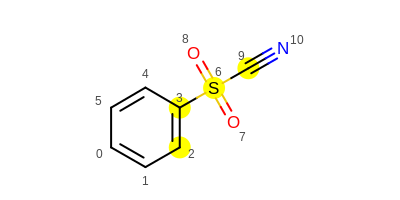

t122a [H:12][c:1]1[c:2]([c:3]([c:4]([c:5]([c:6]1[H:16])[H:15])[S:7](=[O:8])(=[O:9])[C:10]#[N:11])[H:14])[H:13] (2, 3, 6, 9)


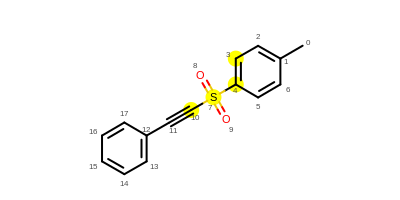

t122a [H:28][c:16]1[c:15]([c:14]([c:13]([c:18]([c:17]1[H:29])[H:30])[C:12]#[C:11][S:8](=[O:9])(=[O:10])[c:5]2[c:4]([c:3]([c:2]([c:7]([c:6]2[H:24])[H:25])[C:1]([H:19])([H:20])[H:21])[H:22])[H:23])[H:26])[H:27] (3, 4, 7, 10)


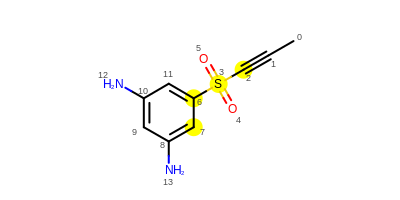

t122a [H:19][c:10]1[c:9]([c:8]([c:7]([c:12]([c:11]1[N:13]([H:21])[H:22])[H:20])[S:4](=[O:5])(=[O:6])[C:3]#[C:2][C:1]([H:15])([H:16])[H:17])[H:18])[N:14]([H:23])[H:24] (2, 3, 6, 7)


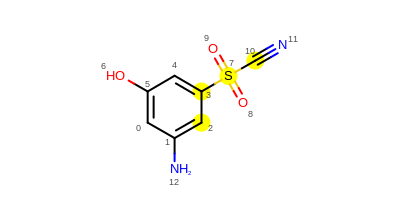

t122a [H:14][c:1]1[c:2]([c:3]([c:4]([c:5]([c:6]1[O:7][H:17])[H:16])[S:8](=[O:9])(=[O:10])[C:11]#[N:12])[H:15])[N:13]([H:18])[H:19] (2, 3, 7, 10)


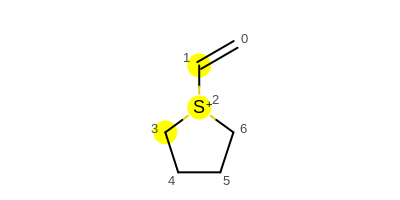

t116c [H:8][C:1](=[C:2]([H:10])[S+:3]1[C:4]([C:5]([C:6]([C:7]1([H:17])[H:18])([H:15])[H:16])([H:13])[H:14])([H:11])[H:12])[H:9] (1, 2, 3, 10)


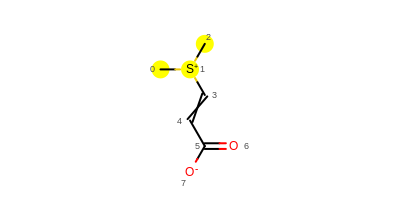

t116c [H:16][C:5](=[C:4]([H:15])[S+:2]([C:1]([H:9])([H:10])[H:11])[C:3]([H:12])([H:13])[H:14])[C:6](=[O:7])[O-:8] (0, 1, 2, 11)


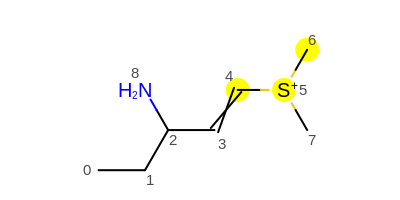

t116c [H:16][C:4](=[C:5]([H:17])[S+:6]([C:7]([H:18])([H:19])[H:20])[C:8]([H:21])([H:22])[H:23])[C:3]([H:15])([C:2]([H:13])([H:14])[C:1]([H:10])([H:11])[H:12])[N:9]([H:24])[H:25] (4, 5, 6, 17)


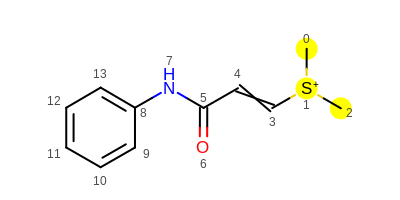

t116c [H:26][c:12]1[c:11]([c:10]([c:9]([c:14]([c:13]1[H:27])[H:28])[N:8]([H:23])[C:6](=[O:7])[C:5](=[C:4]([H:21])[S+:2]([C:1]([H:15])([H:16])[H:17])[C:3]([H:18])([H:19])[H:20])[H:22])[H:24])[H:25] (0, 1, 2, 17)


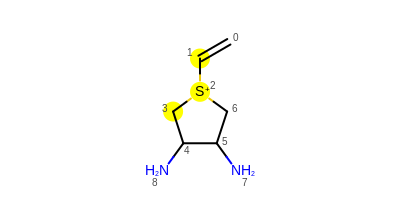

t116c [H:10][C:1](=[C:2]([H:12])[S+:3]1[C:4]([C:5]([C:6]([C:7]1([H:17])[H:18])([H:16])[N:8]([H:19])[H:20])([H:15])[N:9]([H:21])[H:22])([H:13])[H:14])[H:11] (1, 2, 3, 12)


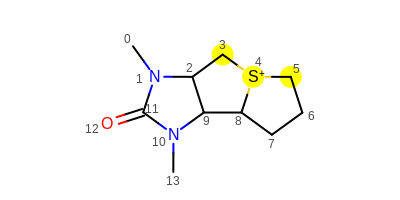

t116c [H:23][C:7]1([C:8]([C:9]2([C:10]3([C:3]([C:4]([S+:5]2[C:6]1([H:21])[H:22])([H:19])[H:20])([N:2]([C:12](=[O:13])[N:11]3[C:14]([H:29])([H:30])[H:31])[C:1]([H:15])([H:16])[H:17])[H:18])[H:28])[H:27])([H:25])[H:26])[H:24] (3, 4, 5, 20)


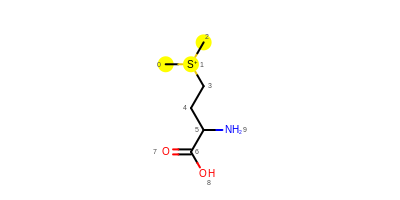

t116c [H:11][C:1]([H:12])([H:13])[S+:2]([C:3]([H:14])([H:15])[H:16])[C:4]([H:17])([H:18])[C:5]([H:19])([H:20])[C:6]([H:21])([C:7](=[O:8])[O:9][H:22])[N:10]([H:23])[H:24] (0, 1, 2, 13)


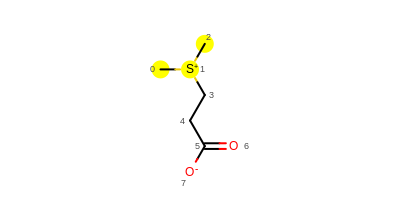

t116c [H:9][C:1]([H:10])([H:11])[S+:2]([C:3]([H:12])([H:13])[H:14])[C:4]([H:15])([H:16])[C:5]([H:17])([H:18])[C:6](=[O:7])[O-:8] (0, 1, 2, 11)


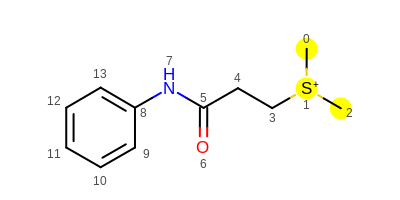

t116c [H:28][c:12]1[c:11]([c:10]([c:9]([c:14]([c:13]1[H:29])[H:30])[N:8]([H:25])[C:6](=[O:7])[C:5]([H:23])([H:24])[C:4]([H:21])([H:22])[S+:2]([C:1]([H:15])([H:16])[H:17])[C:3]([H:18])([H:19])[H:20])[H:26])[H:27] (0, 1, 2, 17)


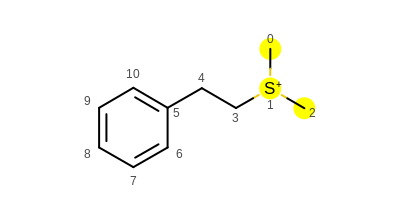

t116c [H:24][c:9]1[c:8]([c:7]([c:6]([c:11]([c:10]1[H:25])[H:26])[C:5]([H:20])([H:21])[C:4]([H:18])([H:19])[S+:2]([C:1]([H:12])([H:13])[H:14])[C:3]([H:15])([H:16])[H:17])[H:22])[H:23] (0, 1, 2, 14)


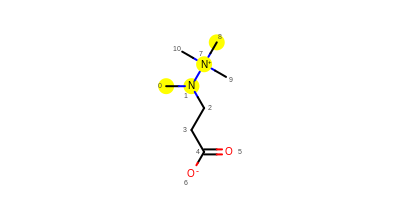

t133a [H:12][C:1]([H:13])([H:14])[N:2]([C:3]([H:15])([H:16])[C:4]([H:17])([H:18])[C:5](=[O:6])[O-:7])[N+:8]([C:9]([H:19])([H:20])[H:21])([C:10]([H:22])([H:23])[H:24])[C:11]([H:25])([H:26])[H:27] (0, 1, 7, 8)


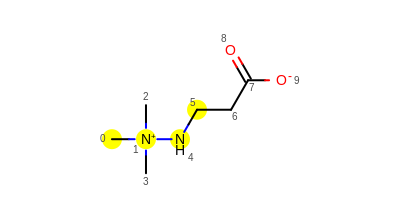

t133a [H:11][C:1]([H:12])([H:13])[N+:2]([C:3]([H:14])([H:15])[H:16])([C:4]([H:17])([H:18])[H:19])[N:5]([H:20])[C:6]([H:21])([H:22])[C:7]([H:23])([H:24])[C:8](=[O:9])[O-:10] (0, 1, 4, 5)


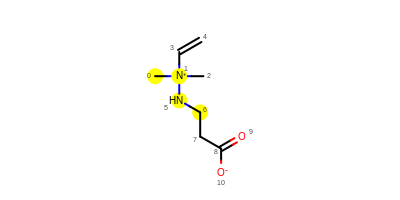

t133a [H:19][C:5](=[C:4]([H:18])[N+:2]([C:1]([H:12])([H:13])[H:14])([C:3]([H:15])([H:16])[H:17])[N:6]([H:21])[C:7]([H:22])([H:23])[C:8]([H:24])([H:25])[C:9](=[O:10])[O-:11])[H:20] (0, 1, 5, 6)


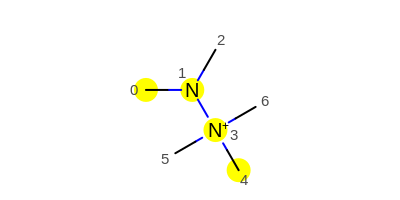

t133a [H:8][C:1]([H:9])([H:10])[N:2]([C:3]([H:11])([H:12])[H:13])[N+:4]([C:5]([H:14])([H:15])[H:16])([C:6]([H:17])([H:18])[H:19])[C:7]([H:20])([H:21])[H:22] (0, 1, 3, 4)


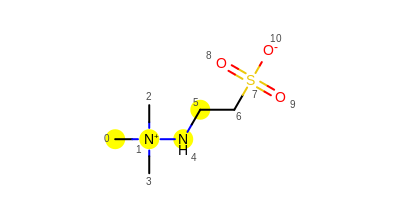

t133a [H:12][C:1]([H:13])([H:14])[N+:2]([C:3]([H:15])([H:16])[H:17])([C:4]([H:18])([H:19])[H:20])[N:5]([H:21])[C:6]([H:22])([H:23])[C:7]([H:24])([H:25])[S:8](=[O:9])(=[O:10])[O-:11] (0, 1, 4, 5)


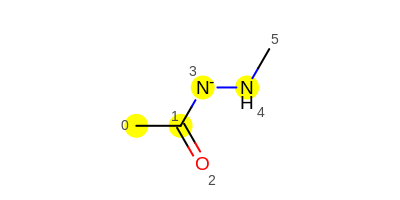

t74a [H:7][C:1]([H:8])([H:9])[C:2](=[O:3])[N-:4][N:5]([H:10])[C:6]([H:11])([H:12])[H:13] (0, 1, 3, 4)


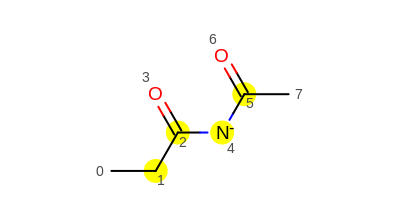

t74a [H:14][C:8]([H:15])([H:16])[C:6](=[O:7])[N-:5][C:3](=[O:4])[C:2]([H:12])([H:13])[C:1]([H:9])([H:10])[H:11] (1, 2, 4, 5)


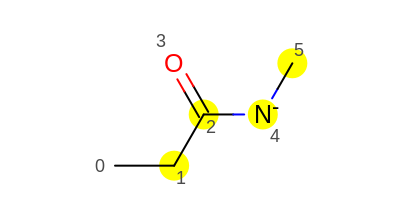

t74a [H:7][C:1]([H:8])([H:9])[C:2]([H:10])([H:11])[C:3](=[O:4])[N-:5][C:6]([H:12])([H:13])[H:14] (1, 2, 4, 5)


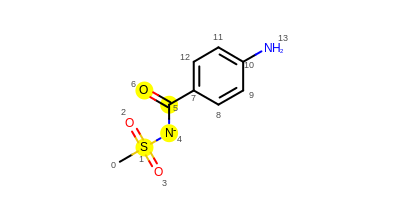

t74a [H:18][c:9]1[c:10]([c:11]([c:12]([c:13]([c:8]1[C:6](=[O:7])[N-:5][S:2](=[O:3])(=[O:4])[C:1]([H:15])([H:16])[H:17])[H:21])[H:20])[N:14]([H:22])[H:23])[H:19] (1, 4, 5, 6)


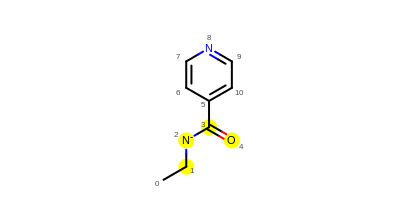

t74a [H:17][c:7]1[c:8]([n:9][c:10]([c:11]([c:6]1[C:4](=[O:5])[N-:3][C:2]([H:15])([H:16])[C:1]([H:12])([H:13])[H:14])[H:20])[H:19])[H:18] (1, 2, 3, 4)


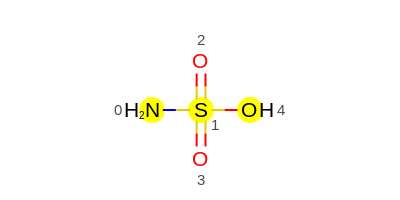

t157 [H:6][N:1]([H:7])[S:2](=[O:3])(=[O:4])[O:5][H:8] (0, 1, 4, 7)


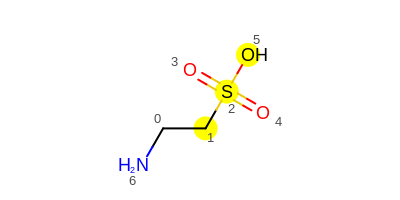

t157 [H:8][C:1]([H:9])([C:2]([H:10])([H:11])[S:3](=[O:4])(=[O:5])[O:6][H:12])[N:7]([H:13])[H:14] (1, 2, 5, 11)


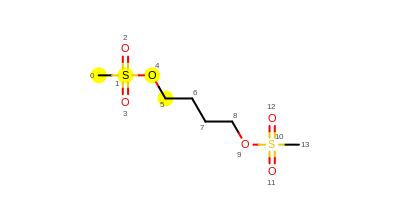

t157 [H:15][C:1]([H:16])([H:17])[S:2](=[O:3])(=[O:4])[O:5][C:6]([H:18])([H:19])[C:7]([H:20])([H:21])[C:8]([H:22])([H:23])[C:9]([H:24])([H:25])[O:10][S:11](=[O:12])(=[O:13])[C:14]([H:26])([H:27])[H:28] (0, 1, 4, 5)


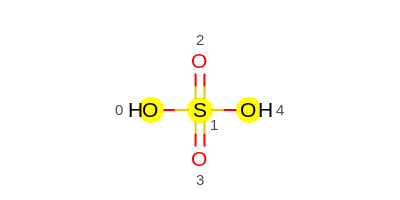

t157 [H:6][O:1][S:2](=[O:3])(=[O:4])[O:5][H:7] (0, 1, 4, 6)


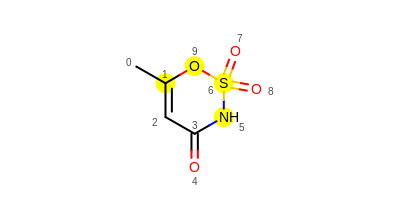

t157 [H:14][C:3]1=[C:2]([O:10][S:7](=[O:8])(=[O:9])[N:6]([C:4]1=[O:5])[H:15])[C:1]([H:11])([H:12])[H:13] (1, 9, 6, 5)


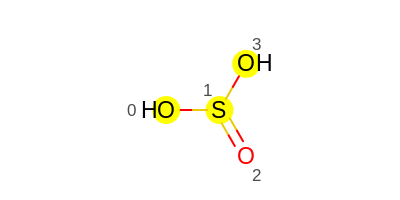

t157a [H:5][O:1][S:2](=[O:3])[O:4][H:6] (0, 1, 3, 5)


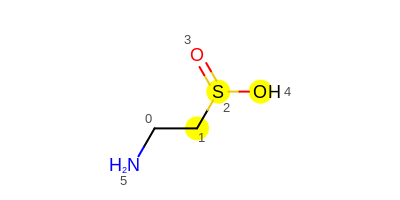

t157a [H:7][C:1]([H:8])([C:2]([H:9])([H:10])[S:3](=[O:4])[O:5][H:11])[N:6]([H:12])[H:13] (1, 2, 4, 10)


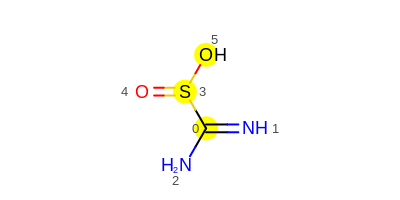

t157a [H:7][N:2]=[C:1]([N:3]([H:8])[H:9])[S:4](=[O:5])[O:6][H:10] (0, 3, 5, 9)


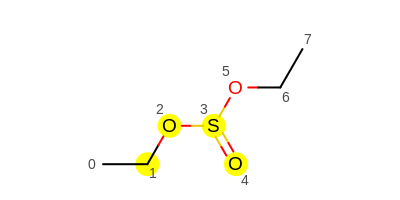

t157a [H:9][C:1]([H:10])([H:11])[C:2]([H:12])([H:13])[O:3][S:4](=[O:5])[O:6][C:7]([H:14])([H:15])[C:8]([H:16])([H:17])[H:18] (1, 2, 3, 4)


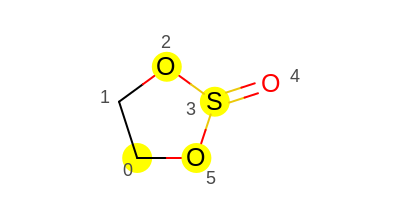

t157a [H:7][C:1]1([C:2]([O:3][S:4](=[O:5])[O:6]1)([H:9])[H:10])[H:8] (0, 5, 3, 2)


In [4]:
smilesdict={'t130b' : ['C1=CC=C(C=C1)S(=O)(=O)NN', 'CS(=O)(=O)NN(CC)S(=O)(=O)C', 'CCOC1=CC=C(C=C1)S(=O)(=O)NN', 'CN(C)C1=CC=CC2=C1C=CC=C2S(=O)(=O)NN', 'CS(=O)(=O)NN(CC)S(=O)(=O)C'],
't132b' : ['CC(C)NC(=O)C1=CC=C(C=C1)CNNC', 'CCNNC', 'CCNNCS(=O)(=O)C', 'C1=CC=C(C=C1)CCNN', 'c1ccc(cc1)C(=O)CNN'],
't133':['C1C[N+](CN1)([N+]2(CCNC2)[O-])[O-]',
'C1C[NH+]([NH+]1[O-])[O-]',
'C1CC[N+](CC1)([N+]2(CCCCC2)[O-])[O-]', 'CC(=O)C(C)(C)[NH+]([N+](C)(CCNC(C)(C)C(=O)CN1C=CN=C1[N+](=O)[O-])[O-])[O-]', 'CC(=O)C(C)(C)NCC[N+](C)([NH+](C(C)(C)C(=O)C)[O-])[O-]'],
't133a':['CN(CCC(=O)[O-])[N+](C)(C)C', 'C[N+](C)(C)NCCC(=O)[O-]', 'C[N+](C)(C=C)NCCC(=O)[O-]', 'CN(C)[N+](C)(C)C', 'C[N+](C)(C)NCCS(=O)(=O)[O-]'],
't142b':['CNSN(C)C(=O)ON', 'CN1C(=O)C=CS1', 'CCCCCCCCN1C(=O)C=CS1', 'C1=CC=C2C(=C1)C(=O)NS2', 'C1CCC(CC1)NSC2=NC3=CC=CC=C3S2'],
't142d':['C1=N[S+](NC1=N)[O-]', 'CC(=O)O[S+](C)C', 'CCN=C1C(=N[S+](N1)[O-])N', 'C[S+](C)OS(=O)(=O)c1ccccc1', 'c1ccc(cc1)[S+](c2ccccc2)O'],
't142e':['CN1C(=O)c2cc(c(cc2[S+]1[O-])OC)OC', 'C1(=N[S+](NC1=N)[O-])N', 'CN=C1C(=NCCS)N[S+](N1)[O-]', 'CSCC(N=C1C(=N[S+](N1)[O-])N)O', 'c1cc(oc1)CN=C2C(=N[S+](N2)[O-])N'],
't142f':['c1ccc(cc1)[S+](c2ccccc2)S(=O)(=O)O', 'C[SH+]S(=O)(=O)c1ccccc1', 'COc1ccccc1S(=O)(=O)[S+](C)S(=O)(=O)C', 'CC[S+](CC)S(=O)(=O)c1ccc[nH]1', 'CC[S+](C)S(=O)(=O)O'],
't142c':['CC(C(=O)OC)SP(=S)(OC)OC', 'COP(=S)(OC)SCN1C(=O)c2ccccc2C1=O', 'CCOP(=S)(OCC)S', 'CCSP(=S)(OC(C)C)OC(C)C', 'COP(=S)(OC)Sc1ccccc1'],
't143d':['c1ccc(cc1)C2=NS(=O)ON2', 'C1=NS(=O)ON1', 'Cc1ccs(=O)n1', 'CC(C(=O)C1=NS(=O)ON1)O', 'CCc1cs(=O)nc1N'],
't143e':['CN(C)S(=O)N(C)c1ccccc1', 'CCOS(=O)NC', 'CCOS(=O)Nc1ccccc1', 'CN(C)S(=O)N(C)C', 'NS(=O)O'],
't143f':['C[N+]1(CCCC1)S(=O)O', 'C[N+](C)(C)S(=O)O', 'C[N+](C)(c1ccccc1)S(=O)O', '[NH3+]S(=O)O', 'CC(=O)[NH2+]S(=O)O'],
't122d':['CC1=CC=C(C=C1)S(=O)C#C', 'CC(C)(C)OC#CS(=O)C1=CC=CC=C1', 'C1=CC=C(C=C1)C2=CN=[C-]S2=O', 'CCCC#CS(=O)C1=CC=C(C=C1)C', 'c1ccc(cc1)S(=O)C#N'],
't122e':['c1ccc(cc1)S(=O)c2ccccc2', 'c1ccc(cc1)S(=O)c2ccc3c(c2)[nH]c(n3)N', 'c1ccc2c(c1)Sc3ccccc3S2=O', 'Cc1ccc2c(c1)N(C(=O)c3ccccc3S2=O)C', 'c1cc(cc(c1)S(=O)c2cc(cc(c2)N)N)N'],
't122a': ['CC#CS(=O)(=O)C1=CC=CC=C1', 'C1=CC=C(C=C1)S(=O)(=O)C#N', 'CC1=CC=C(C=C1)S(=O)(=O)C#CC2=CC=CC=C2', 'CC#CS(=O)(=O)c1cc(cc(c1)N)N', 'c1c(cc(cc1O)S(=O)(=O)C#N)N'],
't116b':['C=C[S+]1CCCC1', 'C[S+](C)C=CC(=O)[O-]', 'CCC(C=C[S+](C)C)N', 'C[S+](C)C=CC(=O)Nc1ccccc1', 'C=C[S+]1CC(C(C1)N)N'],
't116c':['CN1C2C[S+]3CCCC3C2N(C1=O)C', 'C[S+](C)CCC(C(=O)O)N', 'C[S+](C)CCC(=O)[O-]', 'C[S+](C)CCC(=O)Nc1ccccc1', 'C[S+](C)CCc1ccccc1'],
't133':['C1C[N+](CN1)([N+]2(CCNC2)[O-])[O-]', 'C1C[NH+]([NH+]1[O-])[O-]', 'C1CC[N+](CC1)([N+]2(CCCCC2)[O-])[O-]', 'CC[N+](C)([NH+](C(C)(C)C(=O)C)[O-])[O-]', 'CC[NH+]([N+](C)(CC)[O-])[O-]'],
't33a':['CN(CCC(=O)[O-])[N+](C)(C)C', 'C[N+](C)(C)NCCC(=O)[O-]', 'C[N+](C)(C=C)NCCC(=O)[O-]', 'CN(C)[N+](C)(C)C', 'C[N+](C)(C)NCCS(=O)(=O)[O-]'],
't74a':['CC(=O)[N-]NC', 'CCC(=O)[N-]C(=O)C', 'CCC(=O)[N-]C', 'CS(=O)(=O)[N-]C(=O)c1ccc(cc1)N', 'CC[N-]C(=O)c1ccncc1'],
't157':['NS(=O)(=O)O', 'C(CS(=O)(=O)O)N', 'CS(=O)(=O)OCCCCOS(=O)(=O)C', 'OS(=O)(=O)O', 'CC1=CC(=O)NS(=O)(=O)O1'],
't157a': ['OS(=O)O', 'C(CS(=O)O)N', 'C(=N)(N)S(=O)O', 'CCOS(=O)OCC', 'C1COS(=O)O1']
}

torsion_params = list(smilesdict.keys())
smiles=[]
for key, item in smilesdict.items():
    smiles.extend(item)

# create mapped smiles and tag dihedrals to drive
forcefield = ForceField('openff-2.0.0-multiplicity-corrections-v8.offxml')
molecules, cmiles_list = create_tagged_molecules(smiles, forcefield, torsion_params)

In [6]:
from openff.qcsubmit.factories import TorsiondriveDatasetFactory
from openff.qcsubmit import workflow_components

dataset_factory = TorsiondriveDatasetFactory()
dataset_factory.add_workflow_components(workflow_components.StandardConformerGenerator(max_conformers=10))

dataset = dataset_factory.create_dataset(
    dataset_name="OpenFF multiplicity correction torsion drive data v1.0",
    tagline="OpenFF multiplicity correction torsion drive data v1.0",
    description="We created new torsion parameters to correct multiplicity issues in the force field. These torsions are for training of the new torsion parameters which do not have preexisting data in the training datasets.",
    molecules=molecules,
)

dataset.metadata.submitter = "jmaat"
dataset.metadata.long_description_url = (
    "https://github.com/openforcefield/qca-dataset-submission/tree/master/"
    "submissions/"
    "2022-04-29-OpenFF-multiplicity-correction-torsion-drive-data-v1.0"
)

StandardConformerGenerator    :  14%|█▌         | 14/99 [00:00<00:03, 24.01it/s]Warning: : Failed due to unspecified stereochemistry
RDKit ERROR: [20:51:58] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [20:51:58] UFFTYPER: Unrecognized charge state for atom: 4
[20:51:58] UFFTYPER: Unrecognized charge state for atom: 4
[20:51:58] UFFTYPER: Unrecognized charge state for atom: 1
StandardConformerGenerator    :  20%|██▏        | 20/99 [00:01<00:03, 20.79it/s]Warning: : Force field setup failed due to missing parameters
[20:51:58] UFFTYPER: Unrecognized charge state for atom: 6
RDKit ERROR: [20:51:58] UFFTYPER: Unrecognized charge state for atom: 6
StandardConformerGenerator    :  29%|███▏       | 29/99 [00:01<00:02, 28.06it/s]RDKit ERROR: [20:51:59] UFFTYPER: Unrecognized charge state for atom: 6
RDKit ERROR: [20:51:59] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [20:51:59] UFFTYPER: Unrecognized charge state for atom: 11
[20:51:59] UFFTYPER: Unrecognized c

StandardConformerGenerator    :  70%|███████▋   | 69/99 [00:02<00:00, 34.13it/s]RDKit ERROR: [20:52:00] UFFTYPER: Unrecognized charge state for atom: 2
RDKit ERROR: [20:52:00] UFFTYPER: Unrecognized charge state for atom: 1
[20:52:00] UFFTYPER: Unrecognized charge state for atom: 2
[20:52:00] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [20:52:00] UFFTYPER: Unrecognized charge state for atom: 2
RDKit ERROR: [20:52:00] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [20:52:00] UFFTYPER: Unrecognized charge state for atom: 5
RDKit ERROR: [20:52:00] UFFTYPER: Unrecognized charge state for atom: 4
[20:52:00] UFFTYPER: Unrecognized charge state for atom: 2
[20:52:00] UFFTYPER: Unrecognized charge state for atom: 1
[20:52:00] UFFTYPER: Unrecognized charge state for atom: 5
StandardConformerGenerator    :  76%|████████▎  | 75/99 [00:02<00:00, 35.09it/s][20:52:00] UFFTYPER: Unrecognized charge state for atom: 4
RDKit ERROR: [20:52:00] UFFTYPER: Unrecognized charge 

Preparation                   : 100%|███████████| 99/99 [00:01<00:00, 52.54it/s]


In [8]:
from simtk import unit

confs = np.array([len(mol.conformers) for mol in dataset.molecules])

print("Number of unique molecules       ", dataset.n_molecules)
print("Number of filtered molecules     ", dataset.n_filtered)
print("Number of torsion drives         ", dataset.n_records)
print("Number of conformers min mean max",
      confs.min(), "{:6.2f}".format(confs.mean()), confs.max())

masses = []
for molecule in dataset.molecules:
    mass = sum(atom.mass.value_in_unit(unit.dalton) for atom in molecule.atoms)
    masses.append(mass)

print(f'Mean molecular weight: {np.mean(np.array(masses)):.2f}')
print(f'Max molecular weight: {np.max(np.array(masses)):.2f}')
print("Charges:", sorted(set(m.total_charge/m.total_charge.unit for m in dataset.molecules)))

Number of unique molecules        99
Number of filtered molecules      0
Number of torsion drives          99
Number of conformers min mean max 1   2.86 10
Mean molecular weight: 172.23
Max molecular weight: 317.32
Charges: [-1.0, 0.0, 1.0]


In [11]:
dataset.priority = 'high'

for spec, obj in dataset.qc_specifications.items():
    print("Spec:", spec)
    print(obj.dict())

Spec: default
{'method': 'B3LYP-D3BJ', 'basis': 'DZVP', 'program': 'psi4', 'spec_name': 'default', 'spec_description': 'Standard OpenFF optimization quantum chemistry specification.', 'store_wavefunction': 'none', 'implicit_solvent': None, 'maxiter': 200, 'scf_properties': ['dipole', 'quadrupole', 'wiberg_lowdin_indices', 'mayer_indices'], 'keywords': None}


In [12]:
print(dataset.metadata.dict())
dataset.export_dataset("dataset.json.bz2")
dataset.molecules_to_file("dataset.smi", "smi")
dataset.visualize("dataset.pdf", columns=6)

{'submitter': 'jmaat', 'creation_date': datetime.date(2022, 5, 24), 'collection_type': 'TorsionDriveDataset', 'dataset_name': 'OpenFF multiplicity correction torsion drive data v1.0', 'short_description': 'OpenFF multiplicity correction torsion drive data v1.0', 'long_description_url': HttpUrl('https://github.com/openforcefield/qca-dataset-submission/tree/master/submissions/2022-04-29-OpenFF-multiplicity-correction-torsion-drive-data-v1.0', scheme='https', host='github.com', tld='com', host_type='domain', port='443', path='/openforcefield/qca-dataset-submission/tree/master/submissions/2022-04-29-OpenFF-multiplicity-correction-torsion-drive-data-v1.0'), 'long_description': 'We created new torsion parameters to correct multiplicity issues in the force field. These torsions are for training of the new torsion parameters which do not have preexisting data in the training datasets.', 'elements': {'S', 'P', 'O', 'C', 'H', 'N'}}
